# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

import os
path      = os.getcwd()
ampNumber = int(os.path.basename(path)[0])

originalDataset = pd.read_csv('dataset-{}.txt'.format(ampNumber), sep = ',', header = None)
binaryDataset   = []
    
for line in originalDataset.values:
    myList = [1 if j != 0 else 0 for j in line[:40]]
    myList.extend(line[40:])
    binaryDataset.append(myList)

binaryDataset = pd.DataFrame(binaryDataset)

def loadDataset(): 
    dataset = binaryDataset.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataset.values[:, 40 + i])
        gain    = gain.reshape(-1, 1)
        dataset = np.hstack((dataset, gain))
        
        loss    = np.array(binaryDataset.values[:, 40 + i + 1])
        loss    = loss.reshape(-1, 1)
        dataset = np.hstack((dataset, loss))
                
    X, y = np.array(dataset[:, :40]), np.array(dataset[:, 40:])
    return X, y

/home/leandro/Documentos/Mestrado/ACOPResults/acopEnv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Model setup

In [2]:
summaryList = []

#1 regressor per amplifier
X, y = loadDataset()

for j in range(0, ampNumber * 2):
    reg = LazyRegressor(verbose = 0, ignore_warnings = False)

    X_train, X_test, y_train, y_test = train_test_split(X, y[:, j], test_size = 0.3, random_state = 0)
    models, summary                  = reg.fit(X_train, X_test, y_train, y_test)
    
    summaryList.append(summary)

 93%|█████████▎| 40/43 [00:07<00:00,  4.92it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 30%|███       | 13/43 [00:00<00:01, 17.33it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 88%|████████▊ | 38/43 [00:04<00:00,  7.01it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 95%|█████████▌| 41/43 [00:08<00:00,  9.74it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 30%|███       | 13/43 [00:01<00:02, 10.98it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 88%|████████▊ | 38/43 [00:06<00:01,  4.07it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 77%|███████▋  | 33/43 [00:06<00:03,  2.61it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 93%|█████████▎| 40/43 [00:07<00:00,  4.50it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 26%|██▌       | 11/43 [00:00<00:02, 12.85it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 74%|███████▍  | 32/43 [00:05<00:01,  7.99it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 93%|█████████▎| 40/43 [00:06<00:00,  9.35it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 43/43 [00:06<00:00,  6.39it/s]


In [3]:
finalList = []

'''
if i % 2 ==0 -> it's a gain regressor
else         -> it's a loss regressor
'''

for i in range(0, ampNumber * 2, 2): 
    finalList.append([])

    for j in range(min(len(summaryList[i]['RMSE']), len(summaryList[i + 1]['RMSE']))):
        if summaryList[i]['RMSE'].index[j] in summaryList[i + 1]['RMSE']: #checking if gain model exists in loss dataframe
            
            '''
            summaryList[i]['RMSE'].index[j] -> j model's name for regressor i 
            summaryList[i]['RMSE'][j]       -> j model's RMSE for regressor i
            summaryList[i + 1]['RMSE'][j]   -> j model's RMSE for regressor i + 1
            '''
            
            line = [summaryList[i]['RMSE'].index[j], summaryList[i]['RMSE'][j], summaryList[i + 1]['RMSE'][j]]
            finalList[-1].append(line)
    
#finalList[i][j]       -> [name, gain RMSE, loss RMSE] for model #(j + 1) of amp #(i + 1)
print(finalList[0][0]) #  [name, gain RMSE, loss RMSE] for model #1 of amp #1
print(finalList[1][3]) #  [name, gain RMSE, loss RMSE] for model #4 of amp #2

['ElasticNetCV', 2.5343426878501663, 3.153110331432982]
['TransformedTargetRegressor', 1.781413081268645, 3.2134779138122633]


# Draw table

In [4]:
def sort_gain_loss(item):
    return item[1] + item[2]

def prepTable(ampIndex):
    rowLabels = [] # Nomes das linhas
    colLabels = [] # Nomes das colunas   
    values    = [] # Valores das células
    
    colLabels = ["Amp {} Gain".format(ampIndex + 1), "Amp {} Loss".format(ampIndex + 1), "Avg"] 
    
    # TODO: Ordenar esta lista de forma decrescente pela soma de ganho e perda (data[i][1] + data[i][2])
    data = finalList[ampIndex] 
    data.sort(reverse = False, key = sort_gain_loss)
    for entry in data:
        model = entry[0]
        gain  = entry[1]
        loss  = entry[2]
        avg   = round((gain + loss) / 2, 3)
        
        rowLabels.append(model)
        values.append([gain, loss, avg])    
    
    return rowLabels, colLabels, values

In [5]:
def drawTable(ampIndex):
    rows, cols, values = prepTable(ampIndex)
    
    fig = plt.figure(figsize = (15, 5))
    ax  = fig.add_subplot()
    ax.axis("off")

    # TODO: colocar coluna "RMSE (dB)" englobando as colunas de erro (consultar documento)
    ax.table(cellText  = values,
             rowLabels = rows,
             colLabels = cols, 
             loc="upper center")
    
    plt.savefig("amp{}-table".format(ampIndex + 1))

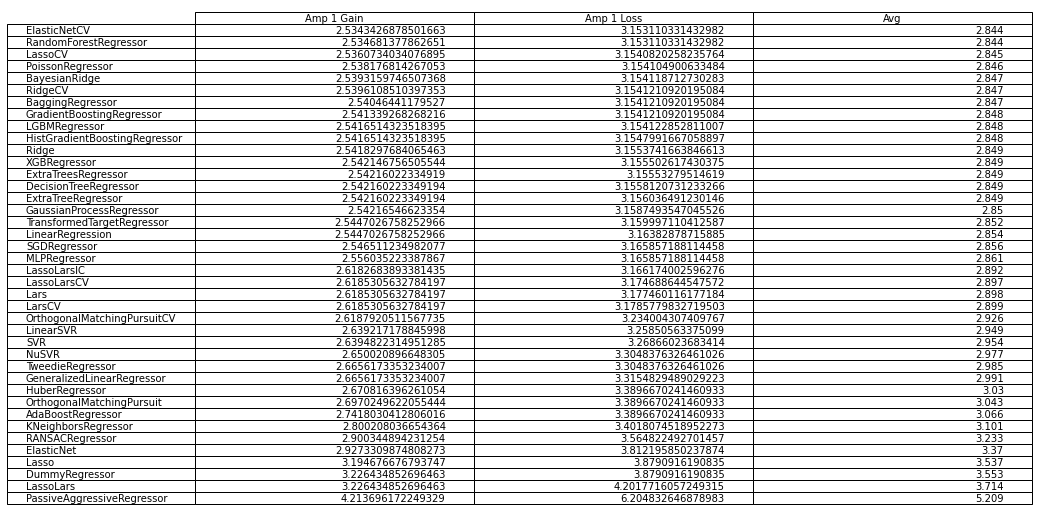

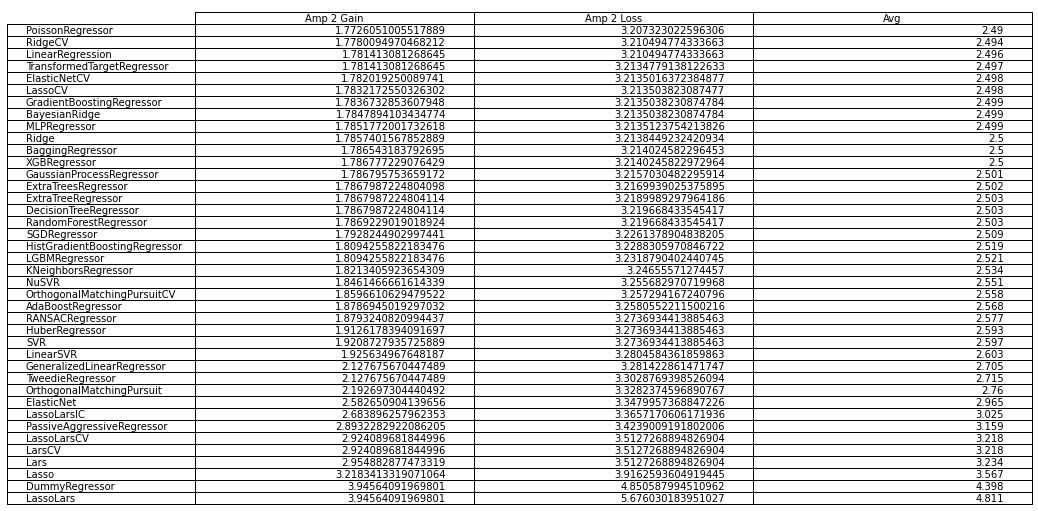

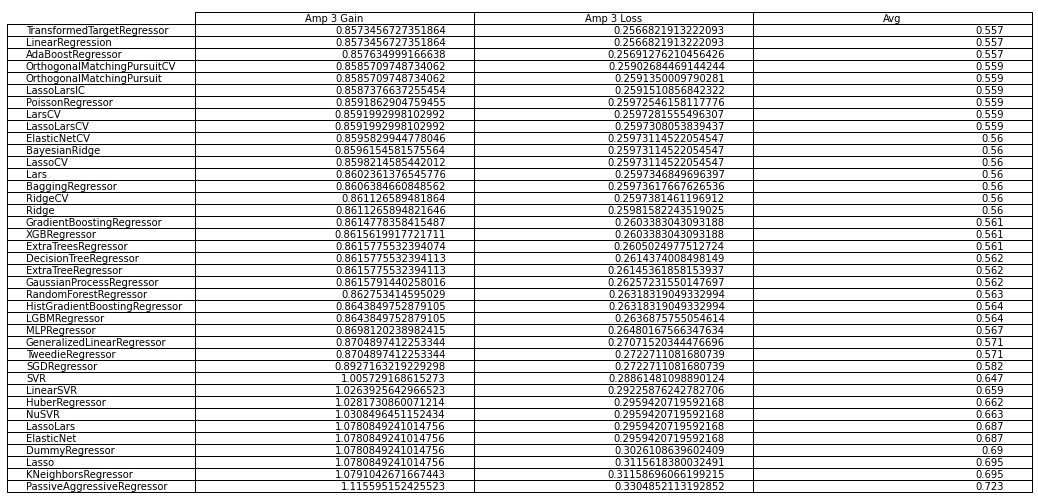

In [6]:
for i in range(ampNumber):
    drawTable(i)